In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/MIT_BIH_ECG"

Mounted at /content/gdrive
/content/gdrive/MyDrive/MIT_BIH_ECG


### Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats

%matplotlib inline

### Variables Definitions

In [2]:
path = './mitbih_database/'
output_loc = "./ECGs_10_classes.hdf5"

classes = ['N', 'L', 'R', 'A', 'V', '/', 'f', 'F', '!', 'j']
# classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)        # here is 5
count_classes = [0]*n_classes 
print(count_classes) 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Prepere Input Files

In [3]:
# Read files
# The return values of os.walk() is a tupple with three elements.
# All filenames in the "path" are contained in the third field.
# The build-in function is used to return the next item in the iterater.
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()


In [4]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

### Data Extraction and Preprocessing

In [5]:
window1_size = 90
window2_size = 166
X = list()
y = list()

# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # signals = stats.zscore(signals)
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if (window1_size <= pos and pos < (len(signals) - window2_size)):
                if (arrhythmia_type in classes):
                    arrhythmia_index = classes.index(arrhythmia_type)
                    count_classes[arrhythmia_index] += 1
                    beat = signals[pos-window1_size:pos+window2_size]     ## REPLACE WITH R-PEAK DETECTION
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(109534, 256) (109534,)


In [14]:
for i in range(10):
    print(y.count(i), end=" ")

75022 8072 7255 2546 7129 7025 982 802 472 229 

In [6]:
df = pd.DataFrame(y[:])
df[:] = df[:].astype(int)
df.to_csv("targets.csv", index=False)
np.savetxt("./ECG/targets.csv", df, delimiter=',')

In [ ]:
pip install pyts

In [6]:
df = pd.DataFrame(X[:])
df = df.T
df.to_csv("ECG_signals.csv", index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,109524,109525,109526,109527,109528,109529,109530,109531,109532,109533
0,963,958,949,955,956,958,965,955,953,957,...,970,984,970,968,972,986,977,969,977,987
1,962,955,947,955,956,958,967,953,956,960,...,973,981,969,971,971,986,977,970,979,986
2,964,955,953,954,956,959,968,952,955,959,...,975,980,975,969,970,985,977,970,983,987
3,963,953,952,953,959,961,969,952,953,961,...,973,978,979,966,971,982,978,971,982,988
4,966,954,953,955,959,961,968,951,953,960,...,972,980,981,965,970,980,978,971,981,988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,959,954,958,957,961,971,951,960,958,962,...,991,975,966,975,987,985,970,978,987,967
252,957,956,955,959,961,971,950,960,962,960,...,990,975,968,974,988,983,969,977,985,966
253,956,953,956,958,959,968,955,957,961,961,...,989,975,970,971,987,981,970,979,987,962
254,957,954,957,961,960,971,956,957,959,961,...,984,972,971,970,986,979,970,976,986,961


In [ ]:
# Author: strongnine (WeChat: strongnine)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from pyts.image import GramianAngularField

#sin_data = np.loadtxt('./ECG_signals.csv', delimiter=",", skiprows=0).reshape(1, -1)  # 加载数据 (load the source data)
f1 = "ECG_signals.csv"
file = pd.read_csv(f1)


In [ ]:
for i in range(2016, len(file.columns)):
    sin_data = (file.iloc[:, i].to_numpy()).reshape(1, -1)
    image_size = 256  # 生成的 GAF 图片的大小 (the size of each GAF image)

    # `method` 的可选参数有：`summation` and `difference`
    # The optional parameters of argument `method`: `summation` and `difference`
    gasf = GramianAngularField(image_size=image_size, method='summation')
    sin_gasf = gasf.fit_transform(sin_data)

    gadf = GramianAngularField(image_size=image_size, method='difference')
    sin_gadf = gadf.fit_transform(sin_data)
    imges = [sin_gasf[0], sin_gadf[0]]
    titles = ['Summation', 'Difference']

    # 两种方法的可视化差异对比
    # Comparison of two different methods
    #fig, axs = plt.subplots(1, 2, constrained_layout=True)
    #for img, title, ax in zip(imges, titles, axs):
        #ax.imshow(img)
        #ax.set_title(title)
    #fig.suptitle('GramianAngularField {}'.format(i+1), y=0.94, fontsize=16)
    #plt.margins(0, 0)
    #plt.savefig("./PDF/GramianAngularField{}.pdf".format(i+1), pad_inches=0)
    #plt.show()
    if i==9:
        print(i+1)
    else:
        print(i+1, end=" ")

    #image.imsave("./ECG/Summation/images{}/GAF_of_Sin{}.png".format(y[i]+1, i+1), sin_gasf[0])  # 保存图片 (save image)
    image.imsave("./ECG/Difference/images{}/GAF_of_Sin{}.png".format(y[i]+1, i+1), sin_gadf[0])  # 保存图片 (save image)
    #np.savetxt("./ECG/CSV/Summation/GAF_of_Sin{}.csv".format(i+1), sin_gasf[0], delimiter=',')  # 保存数据为 csv 文件
    #np.savetxt("./ECG/CSV/Difference/GAF_of_Sin{}.csv".format(i+1), sin_gadf[0], delimiter=',')  # 保存数据为 csv 文件

In [6]:
import cv2

IMG_HEIGHT = 32
IMG_WIDTH = 32
data1 = []
#class_name=[]

for i in range(10):
    img_folder = f'./ECG/Difference/images{i+1}'
    img_data_array=[]
    #for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder)):

        image_path= os.path.join(img_folder, file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float16')
        image /= 255 
        img_data_array.append(image)
        #class_name.append(file)
    data1.append(img_data_array)
    print(i)
print(len(data1))

0
1
2
3
4
5
6
7
8
9
10


In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

X_trains1 = []
X_tests1 = []
y_trains1 = []
y_tests1 = []
label = []
for i in range(10):
    temp = [i for j in range(y.count(i))]
    label.append(temp)
temp = list(data1[0])
X_trains, X_tests, y_trains, y_tests = train_test_split(temp, label[0], test_size=0.2, random_state=1)
       
    
for i in range(1, 10):
    #data = os.listdir(f'./ECG/Difference/images{i+1}')
    #print(len(data), len(label[i]))
    temp = list(data[i])
    X_train, X_test, y_train, y_test = train_test_split(temp, label[i], test_size=0.2, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(img_data_array, y, test_size=0.2, random_state=1)
   
    # Merge inputs and targets
    X_trains1 = np.concatenate((X_trains1, X_train), axis=0)
    X_tests1 = np.concatenate((X_tests1, X_test), axis=0)
    y_trains1 = np.concatenate((y_trains1, y_train), axis=0)
    y_tests1 = np.concatenate((y_tests1, y_test), axis=0)

print(len(X_trains1), len(y_trains1))


87623 87623


In [16]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import keras
import numpy as np

# Model configuration
batch_size = 32
input_shape = (32, 32, 3)
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 10


# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
#inputs = np.concatenate((input_train, input_test), axis=0)
#targets = np.concatenate((target_train, target_test), axis=0)
inputs1 = np.concatenate((X_trains1, X_tests1), axis=0)
targets1 = np.concatenate((y_trains1, y_tests1), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define the model architecture
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(no_classes, activation='softmax'))
print(model1.summary())

# Compile the model
model1.compile(loss=loss_function,
            optimizer=optimizer,
            metrics=['accuracy'])
#model.save('./ECG/model/my_model.h5')
print('Finish!')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [17]:
#re_model = keras.models.load_model("./ECG/model/my_model.h5")
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs1, targets1):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history1 = model1.fit(inputs1[train], targets1[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback])

    # Generate generalization metrics
    scores1 = model1.evaluate(inputs1[test], targets1[test], verbose=0)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores1[0]}; {model1.metrics_names[1]} of {scores1[1]*100}%')
    acc_per_fold.append(scores1[1] * 100)
    loss_per_fold.append(scores1[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
3081/3081 [==============================] - 53s 17ms/step - loss: 0.1842 - accuracy: 0.9506
Epoch 2/10
3081/3081 [==============================] - 73s 24ms/step - loss: 0.0759 - accuracy: 0.9794
Epoch 3/10
3081/3081 [==============================] - 81s 26ms/step - loss: 0.0577 - accuracy: 0.9837
Epoch 4/10
3081/3081 [==============================] - 67s 22ms/step - loss: 0.0486 - accuracy: 0.9860
Epoch 5/10
3081/3081 [==============================] - 79s 26ms/step - loss: 0.0420 - accuracy: 0.9880
Epoch 6/10
3081/3081 [==============================] - 76s 25ms/step - loss: 0.0373 - accuracy: 0.9894
Epoch 7/10
3081/3081 [==============================] - 74s 24ms/step - loss: 0.0325 - accuracy: 0.9901
Epoch 8/10
3081/3081 [==============================] - 77s 25ms/step - loss: 0.0307 - accuracy: 0.9910
Epoch 9/10
3081/3081 [==============================] - 64s 21ms/step -

## Summation

In [19]:
import cv2

IMG_HEIGHT = 32
IMG_WIDTH = 32
data = []
#class_name=[]

for i in range(10):
    img_folder = f'./ECG/Summation/images{i+1}'
    img_data_array=[]
    #for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder)):

        image_path= os.path.join(img_folder, file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float16')
        image /= 255 
        img_data_array.append(image)
        #class_name.append(file)
    data.append(img_data_array)
    print(i)
print(len(data))

0
1
2
3
4
5
6
7
8
9
10


In [96]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

X_trains = []
X_tests = []
y_trains = []
y_tests = []
label = []
for i in range(10):
    temp = [i for j in range(y.count(i))]
    label.append(temp)
temp = list(data[0])
X_trains, X_tests, y_trains, y_tests = train_test_split(temp, label[0], test_size=0.2, random_state=1)
       
    
for i in range(1, 10):
    #data = os.listdir(f'./ECG/Difference/images{i+1}')
    #print(len(data), len(label[i]))
    temp = list(data[i])
    X_train, X_test, y_train, y_test = train_test_split(temp, label[i], test_size=0.2, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(img_data_array, y, test_size=0.2, random_state=1)
   
    # Merge inputs and targets
    X_trains = np.concatenate((X_trains, X_train), axis=0)
    X_tests = np.concatenate((X_tests, X_test), axis=0)
    y_trains = np.concatenate((y_trains, y_train), axis=0)
    y_tests = np.concatenate((y_tests, y_test), axis=0)

print(len(X_trains), len(y_trains))


87623 87623


In [119]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import keras
import numpy as np

# Model configuration
batch_size = 32
input_shape = (32, 32, 3)
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 10


# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
#inputs = np.concatenate((input_train, input_test), axis=0)
#targets = np.concatenate((target_train, target_test), axis=0)
inputs = np.concatenate((X_trains, X_tests), axis=0)
targets = np.concatenate((y_trains, y_tests), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
print(model.summary())

# Compile the model
model.compile(loss=loss_function,
            optimizer=optimizer,
            metrics=['accuracy'])
#model.save('./ECG/model/my_model.h5')
print('Finish!')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 2304)              0         
                                                                 
 dense_30 (Dense)            (None, 256)             

In [120]:
#re_model = keras.models.load_model("./ECG/model/my_model.h5")
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
3081/3081 [==============================] - 78s 25ms/step - loss: 0.2068 - accuracy: 0.9459
Epoch 2/10
3081/3081 [==============================] - 143s 46ms/step - loss: 0.0873 - accuracy: 0.9762
Epoch 3/10
3081/3081 [==============================] - 112s 36ms/step - loss: 0.0678 - accuracy: 0.9810
Epoch 4/10
3081/3081 [==============================] - 115s 37ms/step - loss: 0.0562 - accuracy: 0.9838
Epoch 5/10
3081/3081 [==============================] - 119s 39ms/step - loss: 0.0484 - accuracy: 0.9862
Epoch 6/10
3081/3081 [==============================] - 104s 34ms/step - loss: 0.0426 - accuracy: 0.9876
Epoch 7/10
3081/3081 [==============================] - 104s 34ms/step - loss: 0.0384 - accuracy: 0.9884
Epoch 8/10
3081/3081 [==============================] - 102s 33ms/step - loss: 0.0340 - accuracy: 0.9897
Epoch 9/10
3081/3081 [==============================] - 123s 40m

In [123]:
from sklearn.metrics import classification_report
preds = model.predict(X_tests)
preds = np.argmax(preds.astype('int'), axis=1)
y_tests = y_tests.flatten()
print(classification_report(y_tests, preds, digits=4))

685/685 [==============================] - 5s 8ms/step
              precision    recall  f1-score   support

           0     0.9523    1.0000    0.9756     15005
           1     1.0000    0.9882    0.9941      1615
           2     1.0000    0.8415    0.9139      1451
           3     1.0000    0.6961    0.8208       510
           4     1.0000    0.8962    0.9453      1426
           5     1.0000    0.9907    0.9954      1405
           6     1.0000    0.8122    0.8964       197
           7     1.0000    0.2174    0.3571       161
           8     1.0000    1.0000    1.0000        95
           9     1.0000    0.5000    0.6667        46

    accuracy                         0.9657     21911
   macro avg     0.9952    0.7942    0.8565     21911
weighted avg     0.9674    0.9657    0.9628     21911



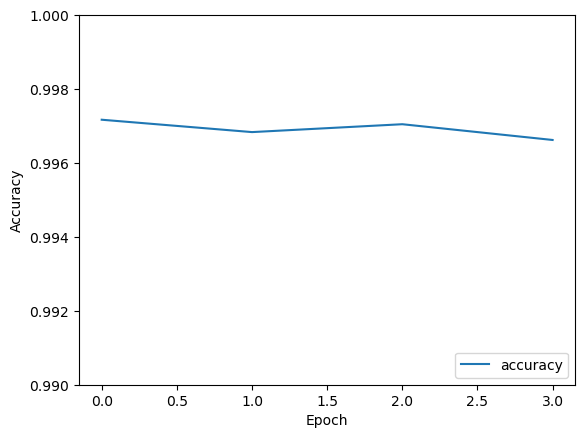

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.99, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)